In this tutorial we make a more practical usecase of self-attention. In the previous tutorial we presented an intuition of self-attention as finding a new representation for each observation of a smaple by attending to other observations via a weighted averaging. We also briefly refer to the terms *query, key* and *value*. Self-attention layer follows pretty much what we explained before but more expressively by defining learnable parameters for the attention process. In other words, each observation in a sample is transformed depending on its role, if it is about to query other observations, it is tranformed by the query matrix. If it is a key to be queried, it is tranformed by the key matrix, and finally it is tranformed by the value matrix weighted averaging.

But before starting with more detailes, let's make a setup for the sake of explaining the self-attention layer intractively. 

## Data prepration

We use MNIST dataset again. Therefore each sample is an image of 28x28. The observations in the sample could are pixels. However we could still work with patch of pixels instead of pixels individually, which is by the way a common practice. In our case each MNIST image is 28x28 and we can make 16 patches of 7x7 as follows:

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from src.data_builder import mnist
from src.visualization.plotting import display_patched_image
import torch.nn.functional as F

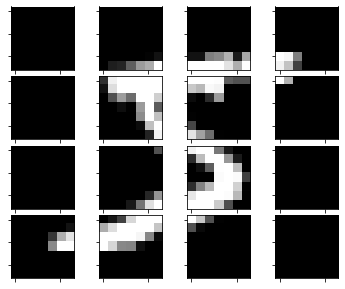

In [6]:
mnist_data = mnist.MNIST()
image_example = mnist_data.train_set.data[0]
patches, patch_size = mnist.image_patching(image_example, num_patch=16)
display_patched_image(patches, patch_size)

Each subimage or patch above is taken as one observation in the image sample, so basically the image is viewed as a *sequence* of subimages.
However, to get the best performance it is quite important to know where each patch belongs to in the original image, in other words the position of each patch matters for recognizing the digits. Therefore, we add an identifier to each patch to contain the positional information. This identifier could be anything as long as it distinctively provides positional information for each patch and it is consistent across all the images. For example, you may want to use numbers from 1 to 16, so that the most left bottom patch is identified by 1 and the most right top one is identified by 16.

However, as in many other machine learning approaches, fusing features should be done with care. Adding positional information is not an exception, and therefore in practice this extra feature is added (or concatenated) to the patch representations in more subtle ways than adding integers or one-hot-encoding. This is beyond the scope of this tutorial as we want to stay focused on the self-attention layer. Thus, we just use a positional embedding based on sinusoidal function to identify each image, and then concatenate it to the patch. So in the rest of this tutorial, it is not only the patch that goes to the self-attention layer, but also it's positional embedding.

In [7]:
from  src.self_attention.utils import get_sinusoidal_encoding

num_patches = 16
embedding_dim = 10  # in the case of concatenation this is a hyperparameter 
positional_embeddings = get_sinusoidal_encoding(num_patches, embedding_dim)

input_to_self_attentation_layer = torch.concat((patches.reshape(16,-1), positional_embeddings), axis=1)
input_to_self_attentation_layer.shape

torch.Size([16, 59])

To summarize, the input image is split into 16 patches of 7x7 and each patch is vectorised and concatenated with 10 variables representing it's position in the image.

## Self-attention layer

Now that the input is ready. lets start with the self-attention layer. This layer basically contains three main linear transformations named *query, key* and *value* matrices, and the output dimension is named attention head size or the embedding size:

In [8]:
input_dim = 59 # 7*7 pixels + 10 positional embedding
embed_dim = 10 # attention head size
query = torch.nn.Linear(input_dim, embed_dim, bias=False)
key = torch.nn.Linear(input_dim, embed_dim, bias=False)
value = torch.nn.Linear(input_dim, embed_dim, bias=False)

Above, we defined three learnable matrixes, which all are supposed to transform the input data. Self-attention can be viewed as weighted linear averaging so that the new representation for each patch is obtained as a linear combination of other pathches. Let's take one patch as an example to elaborate more on the process:

In [9]:
patch_example = input_to_self_attentation_layer[0]
patch_example.shape

torch.Size([59])

First this patch is transformed via query matrix. This makes it possible to have a more expressive modeling:

In [10]:
patch_example_query = query(patch_example)
patch_example_query.shape

torch.Size([10])

Then to define the weights the query patch is matched against all the patches, including itself, to measure its similarity via dot product. However, first all the patches to be quiriedare transformed via the key matrix:

In [12]:
key_patches = key(input_to_self_attentation_layer)
key_patches.shape

torch.Size([16, 10])

and weights can be then calculated and normalise to be between zero and one:

In [13]:
weights = patch_example_query @ key_patches.transpose(1,0)
weights = F.softmax(weights, dim=-1).unsqueeze(0)
weights

tensor([[2.2270e-19, 7.7853e-27, 2.2317e-32, 1.0609e-30, 2.2368e-19, 1.4157e-18,
         2.3803e-05, 1.0890e-18, 2.2578e-19, 1.4716e-26, 7.7874e-11, 2.2276e-19,
         2.3488e-33, 9.9998e-01, 1.3077e-13, 2.1300e-19]],
       grad_fn=<UnsqueezeBackward0>)

The next step is to calculate the output of the self-attention layer by taking the weghted average of the all other patches given the assigned weights. First, again the patches are first transformed via value matrix and then averaged:

In [14]:
value_patches = value(input_to_self_attentation_layer)
attention_output = weights @ value_patches
attention_output

tensor([[205.5148,  14.7546,  74.4948,  56.7472,  45.2748,  27.4483, -74.9525,
          -5.0673,  30.5897, -63.5396]], grad_fn=<MmBackward0>)

This is the new 10-dimensional representaion of the patch based on the self-attention mechanisms. Noting that the matrixes are learnable and this layer can be trained together with other layers of a neural network given some objectives.

 Let's make this layer more formally via Pytorch:

In [16]:
class SelfAttention(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SelfAttention, self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.key = torch.nn.Linear(self.input_dim, self.output_dim, bias=False)
        self.query = torch.nn.Linear(self.input_dim, self.output_dim, bias=False)
        self.value = torch.nn.Linear(self.input_dim, self.output_dim, bias=False)

    def forward(self, x):
        x_query = self.query(x)
        x_key = self.key(x)
        x_value = self.value(x)
        weights = F.softmax(x_query @ x_key.transpose(-1,-2), dim=-1)
        output = weights @ x_value
        return output

In [17]:
attention_layer = SelfAttention(input_dim=input_dim, output_dim=embed_dim)
attention_layer(input_to_self_attentation_layer.unsqueeze(0)).shape

torch.Size([1, 16, 10])

## Multihead attention

It is common to use attention mechanisms multiple times to capture different attention directions. In our MNIST example we may want to attend to different pathches to get different information, For example to recognise the digits, we always want to attend to patches in center of the image, but to distinguish between certain digits, let say 2 and 7, maybe extra attention is required to certain patchs. Having multiple attention mechanism also provides expressivness but at the cost of more parameters.

multiple attention is called multi-head attention and in practice it is simply applying multiple attention mechansim on the input and merging them via a linear layer:

In [19]:
num_head = 5
multi_head_outputs = []
for _ in range(num_head):
    attention_layer = SelfAttention(input_dim=input_dim, output_dim=embed_dim)
    multi_head_outputs.append(attention_layer(input_to_self_attentation_layer.unsqueeze(0)))
multi_head_output = torch.concat(multi_head_outputs, axis=2)
multi_head_output.shape

torch.Size([1, 16, 50])

As you can see the output has 50 dimension (num_head x embed_size). Now we can get back to the requested embed size, 10, by a linear transformation:

In [20]:
final_output =torch.nn.Linear(num_head*embed_dim, embed_dim)(multi_head_output)
final_output.shape

torch.Size([1, 16, 10])